In [85]:
import boto3
import pandas as pd

try:
    # Initialize DynamoDB client
    dynamodb = boto3.resource('dynamodb')

    # Assuming 'pms3003_data' is the name of your DynamoDB table
    table = dynamodb.Table('pms3003_data')

    # Perform the scan operation
    response = table.scan()

    # Retrieve items from the response
    items = response['Items']

    # Continue scanning if there are more items to retrieve
    while 'LastEvaluatedKey' in response:
        response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
        items.extend(response['Items'])

    # Convert the items to a DataFrame
    df = pd.DataFrame(items)

except Exception as e:
    print("Error:", e)


In [86]:
df.head()

,pm1,pm25,pm10,station_number,timestamp
0,5,9,11,1,2024-04-04 09:22:33
1,6,11,13,1,2024-04-03 02:02:40
2,8,14,18,1,2024-04-03 10:20:18
3,15,26,32,1,2024-04-04 22:10:12
4,22,36,47,1,2024-04-04 17:04:12


In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, sosfilt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

In [88]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,pm1,pm25,pm10,station_number,timestamp
0,5,9,11,1,2024-04-04 09:22:33
1,6,11,13,1,2024-04-03 02:02:40
2,8,14,18,1,2024-04-03 10:20:18
3,15,26,32,1,2024-04-04 22:10:12
4,22,36,47,1,2024-04-04 17:04:12


In [89]:
# Define a function to categorize PM2.5 levels
def categorize_pm25_level(pm25_value):
    if pm25_value <= 25:
        return 0
    elif pm25_value <= 50:
        return 1
    elif pm25_value <= 100:
        return 2
    elif pm25_value <= 200:
        return 3
    else:
        return 4

In [90]:
# Apply the function to create a new column 'aqi_category'
df['aqi_category'] = df['pm25'].apply(categorize_pm25_level)

# Print the updated dataframe
print(df['aqi_category'])

0       0
1       0
2       0
3       1
4       1
       ..
5549    0
5550    0
5551    1
5552    1
5553    0
Name: aqi_category, Length: 5554, dtype: int64


In [91]:
df.head()

,pm1,pm25,pm10,station_number,timestamp,aqi_category
0,5,9,11,1,2024-04-04 09:22:33,0
1,6,11,13,1,2024-04-03 02:02:40,0
2,8,14,18,1,2024-04-03 10:20:18,0
3,15,26,32,1,2024-04-04 22:10:12,1
4,22,36,47,1,2024-04-04 17:04:12,1


In [92]:
# Exclude the 'timestamp' column from the input data
x = df.drop(["aqi_category", "station_number", "timestamp"], axis=1)
x.head()

,pm1,pm25,pm10
0,5,9,11
1,6,11,13
2,8,14,18
3,15,26,32
4,22,36,47


In [93]:
y =df.aqi_category
y.head()

0    0
1    0
2    0
3    1
4    1
Name: aqi_category, dtype: int64

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

In [95]:
from sklearn.ensemble import GradientBoostingClassifier

# Example of tuning hyperparameters
gb_classifier_tuned = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_classifier_tuned.fit(x_train, y_train)
y_pred_tuned = gb_classifier_tuned.predict(x_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("Tuned Model Accuracy:", accuracy_tuned)

Tuned Model Accuracy: 1.0


In [96]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_tuned)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_tuned))

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1117
           1       1.00      1.00      1.00       550

    accuracy                           1.00      1667
   macro avg       1.00      1.00      1.00      1667
weighted avg       1.00      1.00      1.00      1667



In [97]:
# Perform cross-validation
cv_scores = cross_val_score(gb_classifier_tuned, x, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


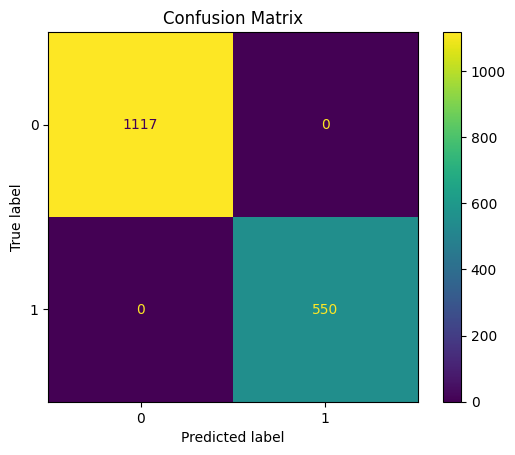

In [98]:
# Assuming you already have model.predicted values
y_pred = gb_classifier_tuned.predict(x_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=gb_classifier_tuned.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [99]:
joblib.dump(gb_classifier_tuned, 'gb_classifier_model_nontune.pkl')

['gb_classifier_model.pkl']